# Homework 5 - Taming text

## Introduction

In this homework, a large corpus of emails released in public during the Hillary Clinton email controversy will be explored. The corpus is stored in `Data` directory. More informtion of the schema is available [here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

In [1]:
import nltk
import string
import pickle
import pycountry
import numpy as np
import pandas as pd
from cleaning import *
from functools import partial
from wordcloud import WordCloud
%matplotlib inline

## 1. Word clouds
Generate two word clouds:
* One based on the raw corpus
* One based on the corpus pre-processed using the standard text pipeline. 

### a. __Raw text__

The data we are going to use for producing the clouds is taken from the file `Emails.csv` and refers to the column `MetadataSubject, ExtractedSubject, Extractedbody`. Hence, before proceeding to build up a unique cloud, we sould concatenate all the body and subject of the emails. In particular, we do the following:
* Import the data related to the Emails.

In [2]:
# Read data
emails = pd.read_csv('Data/Emails.csv', sep = ',')
emails.sample(3)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
484,485,C05758753,FW:,abedinh@state.gov,H,80.0,2009-06-11T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/2_3_4/DOC_0C05...,F-2014-20439,...,NaN,NaN,NaN,NaN,F-2014-20439,C05758753,06/30/2015,RELEASE IN PART,NaN,UNCLASSIFIED U.S. Department of State Case No....
1122,1123,C05760375,KOUCHNER JUST PUT A CALL INTO YOU. CHECKING ON...,abedinh@state.gov,H,80.0,2009-12-06T05:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/10_11_15_16/DO...,F-2014-20439,...,'abedinh@state.gov',H <hrod17@clintonemail.com>,NaN,"Sunday, December 6, 2009 12:47 PM",F-2014-20439,C05760375,06/30/2015,RELEASE IN FULL,"I need to call Karzai, Shaun Woodward and then...",UNCLASSIFIED U.S. Department of State Case No....
1291,1292,C05760679,PULLING BACK,H,"Mills, Cheryl D",32.0,2009-04-02T04:00:00+00:00,2015-07-31T04:00:00+00:00,DOCUMENTS/HRCEmail_JulyWeb/Web_18-20M/DOC_0C05...,F-2014-20439,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Sullivan, Jacob J; Kennedy, Patrick F; Steinbe...","Thursday, April 02, 2009 1:21 PM",F-2014-20439,C05760679,07/31/2015,RELEASE IN PART,FYI,UNCLASSIFIED U.S. Department of State Case No....


Due to the presence of missing data for the variable related to the `Subject`:
* Get the indeces of the email without `MetadataSubject`

In [3]:
index_null = emails[emails['MetadataSubject'].isnull()].index

* Get the indeces of the email without `ExtractedSubject`

In [4]:
index_null_extracted = emails[emails['ExtractedSubject'].isnull()].index

Then, compute the intersection to see which are the emails that merging the information contained in the two columns will remain unknown.

In [5]:
# Number that should remain null
print ("Number of email we do not know the subject: ", len(set(index_null).intersection(set(index_null_extracted))))

Number of email we do not know the subject:  250


We prefer using the `MetadataSubject` since it appears more cleaned, we use the information in `ExtractedSubject` though. Here we replace the null values of the former with those of the latter, whether it has it.

In [6]:
# For each mail without the subject
for i in index_null:
    emails.loc[i,'MetadataSubject'] = emails.loc[i, 'ExtractedSubject']

The entries that remain nulls even after these operation are filled in with the expression `No title`. The same is done for the bodies of the emails substituting the empty fields with the expression `No body text`.

In [7]:
# Get the subject - replacing nans
emails['MetadataSubject'].fillna('No title', inplace = True)

In [8]:
# Get bodies - replace nans
emails['ExtractedBodyText'].fillna('No body text', inplace = True)

* Extract the column relates to the corpus.

In [9]:
# Useful data
email_corpus = emails[['MetadataSubject', 'ExtractedBodyText']]

* Create a *unique* corpus.

We choose the columns of the data that provide some useful information - merged columns for subject of the email and also body text.

In [10]:
# Create a unique string from the list of entries for the subject feature
unique_corpus_1 = ' '.join([email_corpus['MetadataSubject'][i] for i in range(len(email_corpus))])

# Create a unique string from the list of entries for the body feature
unique_corpus_2 = ' '.join([email_corpus['ExtractedBodyText'][i] for i in range(len(email_corpus))])

In [11]:
# Get the raw corpus
unique_corpus = ' '.join([unique_corpus_1] + [unique_corpus_2])

At first we remove all the characters that contain punctuation.

In [12]:
for c in string.punctuation:
    unique_corpus = unique_corpus.replace(c," ")

Thus, we generate the word cloud. For the moment, in order to indentify the most frequent words, we decide not to fix the maximum font size.

In [13]:
# Generate the word cloud 
wordcloud = WordCloud().generate(unique_corpus)

Visualize the output cloud!

(-0.5, 399.5, 199.5, -0.5)

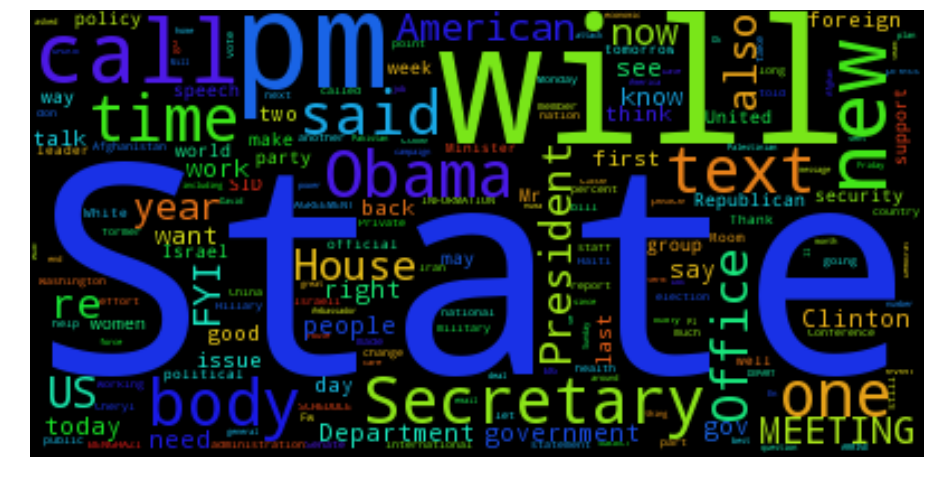

In [14]:
# Display the generated cloud
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")

### b. Pre-processed text

To preprocess the text we proceed with these steps ([`clean_entire_corpus`](cleaning.py)):

* Tokenize the corpus and we receive the list of words to further procedure.
* Remove meaningless, short tokens and we put the rest of them into lowercase.
* Get rid of a list of stowords extended by the common words we found in the cloud above (to extend the list of meaningless words we go through the list of the firs words cloud)
* We considered using stemming techniques but we abandoned this idea while it couldn't give us more descriptive view of the email content. Also we find not stemmed words easier to proceed.

In [15]:
# Get the list to extend the stopwords list
extra = [line.rstrip('\n').strip() for line in open('extra_stopwords.txt')]

Thus, we preprocess the code.

In [16]:
# Obtain the corpus
corpus = clean_entire_corpus(unique_corpus, 3, extra)

And we proceed generating the cloud of words.

(-0.5, 399.5, 199.5, -0.5)

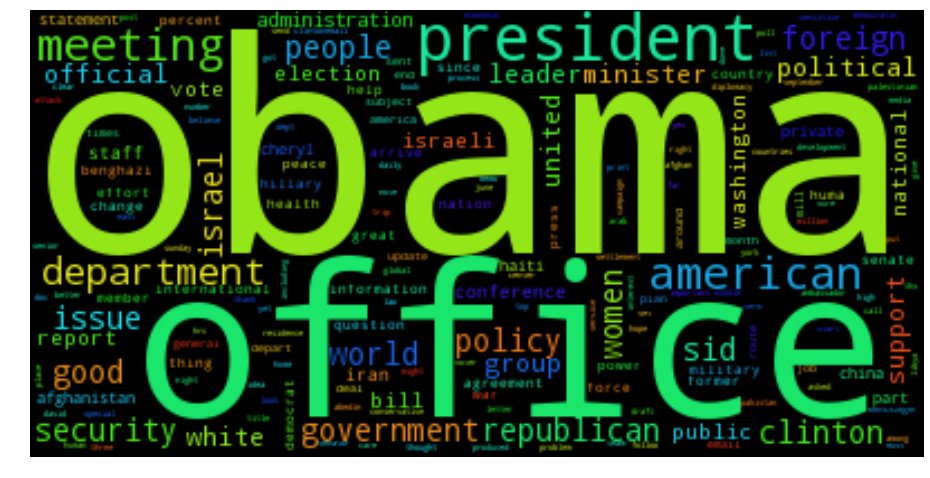

In [17]:
plt.figure(figsize=(20,8))
plt.imshow(WordCloud().generate(corpus))
plt.axis("off")

Comparing the two clouds we clearly see how different they are in terms of *"key words"*. The raw corpus contains a lot of meaningless words that occur often in the emails (just because element of the grammar or standard part of a body email), it leads to the lack of information in the cloud. Beside, the second cloud, thanks to the cleaning, seems to be more capable of describing the email contents.

## 2. Country mentions and sentiment analysis

In this task our goal is to:
* Find all the mentions of world countries in the whole corpus.
* Perform sentiment analysis on every email message.

To find all the mentions of countries we need to clean again the data, the procedure we use is different. Hence, we use another function that also extends the list of words that we don't want the body emails to contain. In particulr what we observed is the precence of ISO2 code to identify a country that corresponds to a very common token in the email like `re` which means `response` but is also identified as a country `Réunion`. The same thing happens for some ISO3 code: `ago` used in english as time expression, if we refer to country represents the `Angola`. The list of words that can be misleading in these terms are stored in the file [`extended_country`](extended_country.txt).

In [18]:
# Words to exclude
stop_words = set(stopwords.words('english') + extra)

# Words to exclude for the explained reason related to the countries
extension = [line.rstrip('\n').strip() for line in open('extended_country.txt')]

We create a new column with the processed text expressed as list of words.

In [19]:
# Define the elements of the new column
new_col = []
for i in emails.index:
     new_col += [clean_body_country(emails.loc[i, 'ExtractedBodyText'], stop_words, extension, 2)]

# Create the column
emails['ExtractedBodyText_2'] = new_col 

Thus, we define a set of all the possible countries (expressed in different ways) and a dictionary of the form

                {'name_country' : ['ISO2', 'ISO3', 'Other_way_1', .., 'Other_way_n']}
            
that will be used to check whether a word is or not a country. The `'Other_way_k'` have been added manually.

In [20]:
# Get the list of countries
list_country = list(pycountry.countries)

# Define the country dictionary and the country set
country_dictionary, country_set = country_names(list_country)

Therefore, we count in how many emails each country is mentioned. The function is stored [here](cleaning.py).

In [21]:
# Compute the mentions and the store the sentiment for each 
#mentions_dictionary, sentiment_dictionary = country_mentions_sentiment_vader(country_dictionary, country_set, emails)

In [22]:
# Save the dictionaries
#pickle.dump(sentiment_dictionary, open("vader_sentiment.p", "wb"))  
#pickle.dump(mentions_dictionary, open("mentions.p", "wb"))  

In [23]:
# Load the dictionary
sentiment_dictionary = pickle.load(open("vader_sentiment.p", "rb"))
mentions_dictionary = pickle.load(open("mentions.p", "rb"))

We decide to represent the country that have been mentioned in more than 30 mails.

In [24]:
# Keep countries with mentions greater than 30
dict_big_mentions = {}

# For each country
for c in list(mentions_dictionary.keys()):
    # Keep those mentioned in more than 30 emails
    if mentions_dictionary[c] > 30:
        dict_big_mentions[c] = mentions_dictionary[c]

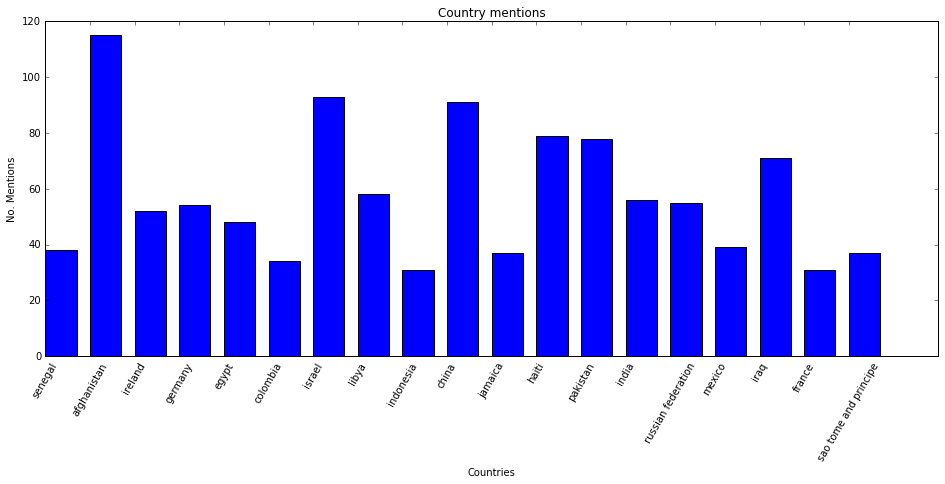

In [25]:
# Plot mentions
plot_mentions(dict_big_mentions)

On the whole, the country that are most mentioned don't sound incorrect. We see that Afganistan, China, Israel and Iran are the ones mentiones in the highest number of mails. It means that the country detection is not so bad, it should be made better in order to avoid counting as country words that are not.

So now, we compute the sentiment contained in the mails respect to some country (those that are mentioned more that the others).
* We define a dictionary that stores all the final information (the sentiment is computed as the difference between the positive and negative one. It means that whether the obtained values is greater that 0 the email fluctuated between the neutrality and the positivity.)

In [26]:
# Final dictionary
final_dict = {}
for k in list(dict_big_mentions):
    final_dict[k] = {}
    
    final_dict[k]['sentiment'] = np.mean(sentiment_dictionary[k]['pos']) - np.mean(sentiment_dictionary[k]['neg'])
    final_dict[k]['mention'] = dict_big_mentions[k]

* Visualize through a barplot. Where the for each country is represented the number of mentions and the sentiment of the mail.

In [27]:
# Define the df to plot
df_sentiment = pd.DataFrame.from_dict(final_dict, orient = 'index')

* The method used is the Vader, which compute the polarity of the text.

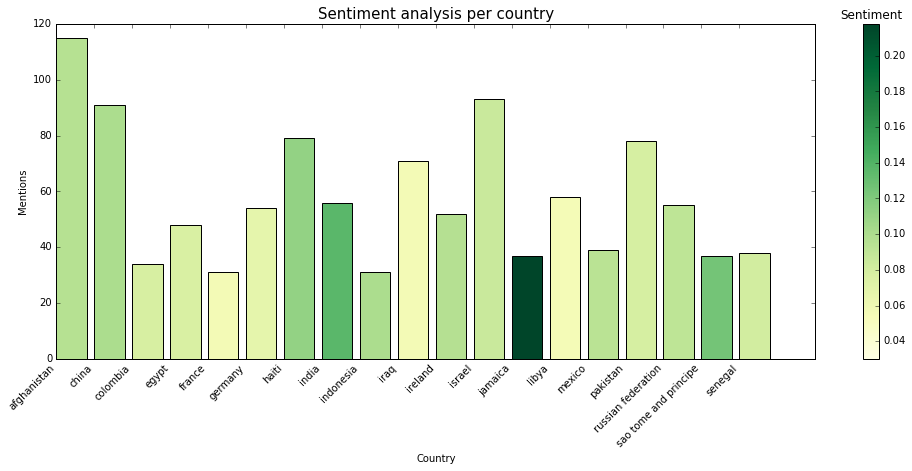

In [28]:
# Plot
plot_sentiment(df_sentiment)

* Repeat the same operation with another method which define the sentiment of a text according to the majority of negative/neutral/positive words. When the mail is classified as negative we assign -1, when is positive 1 and when is neutral 0.

In [29]:
#sentiment_dictionary = sentiment_liu(country_dictionary, country_set, emails)

* Save the dictionary in an external file

In [30]:
# Save the dictionary
#pickle.dump(sentiment_dictionary, open("liu_sentiment.p", "wb"))  

In [31]:
# Load the dictionary
sentiment_dictionary = pickle.load(open("liu_sentiment.p", "rb"))

* Obtain the final result about the sentiment analysis. In particular, we compute the mean of the sentiment obtained for each mail where the country is mentioned. The `sentiment` will then vary between -1 and 1, where -1 is negative and 1 positive, neutral if near to 0.

In [32]:
final_dict = {}
for k in list(dict_big_mentions):
    final_dict[k] = {}
    
    final_dict[k]['sentiment'] = np.mean(sentiment_dictionary[k]['sentiment'])
    final_dict[k]['mention'] = dict_big_mentions[k]

In [33]:
# Define the df to plot
df_sentiment = pd.DataFrame.from_dict(final_dict, orient = 'index')

* Plot the results

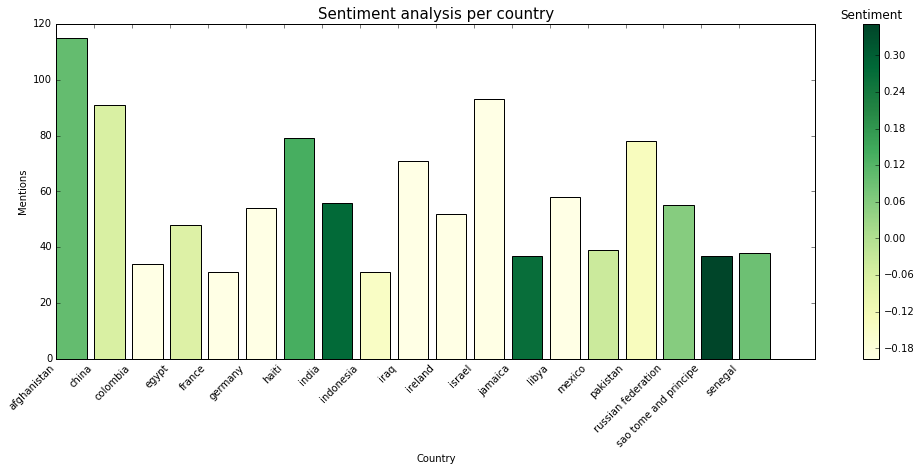

In [34]:
plot_sentiment(df_sentiment)

The results obtained from the two analysis are not the same. In particular, it seems that the second one puts more emphasis on the results obtained using the first one. 
* Liu method define negative sentiments, but since their proximity to 0, they can still be considered neutral. At the same time the country that have a positive sentiment seem to result positive with higher sentiment than for the Vader analysis.

## 3.

Import libraries and logging for gensim

In [35]:
import numpy as np
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Import gensim

In [36]:
import gensim

/home/pawello/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [37]:
from gensim.utils import smart_open, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models import ldamodel

Get the emails bodies as lists.

In [38]:
doc_tokens = emails['ExtractedBodyText_2'].tolist()

Create a dictionnary from the email bodies

In [39]:
id2word = corpora.Dictionary(doc_tokens)

Filter out words that appear less than 2 times and those that appear in more than 50% of the campus. These are not suitable for topic candidates.

In [40]:
id2word.filter_extremes(no_below=2, no_above=0.5) #filter out 

Look at the dictionnary and save it.

In [41]:
print(id2word)

Dictionary(15464 unique tokens: ['tanned', 'workshop', 'manufacturing', 'asean', 'repudiated']...)


In [42]:
id2word.save('topic.dict')

Create corpus by vectorizing occurences of all tokens according to the dictionnary

In [43]:
corpus = [id2word.doc2bow(text) for text in doc_tokens]

Train LDA model with 5 topics

In [44]:
lda = ldamodel.LdaModel(corpus, id2word=id2word, num_topics=5)

Show the topics

In [45]:
lda.show_topics()

[(0,
  '0.006*"2010" + 0.004*"china" + 0.003*"stategov" + 0.003*"2009" + 0.003*"policy" + 0.003*"nt" + 0.003*"people" + 0.002*"great" + 0.002*"obama" + 0.002*"government"'),
 (1,
  '0.005*"nt" + 0.004*"people" + 0.004*"government" + 0.003*"political" + 0.003*"president" + 0.003*"american" + 0.003*"united" + 0.003*"yes" + 0.002*"14" + 0.002*"world"'),
 (2,
  '0.006*"obama" + 0.006*"nt" + 0.004*"women" + 0.004*"president" + 0.004*"people" + 0.003*"israel" + 0.003*"bill" + 0.003*"boehner" + 0.003*"government" + 0.003*"2010"'),
 (3,
  '0.011*"office" + 0.006*"meeting" + 0.006*"obama" + 0.005*"department" + 0.005*"president" + 0.004*"nt" + 0.004*"washington" + 0.003*"foreign" + 0.003*"conference" + 0.003*"private"'),
 (4,
  '0.017*"2010" + 0.013*"stategov" + 0.008*"ok" + 0.008*"nt" + 0.006*"14" + 0.006*"b6" + 0.006*"cheryl" + 0.005*"2009" + 0.005*"clintonemailcom" + 0.005*"huma"')]

Do a run of LDA for various topic sizes

In [46]:
topic_size = [10,20,30,40,50]
lda_ = []
i = 0
for topic in topic_size:
    lda_.append(ldamodel.LdaModel(corpus, id2word=id2word, num_topics=topic))
    i+=1


Print the results

In [47]:
for ld in lda_ :
    ld.print_topics(-1)

In this part we want to do topic modeling over grouped documents by sender. The reason is that for the corpus previously used, a lot of the documents i.e. e-mails are too short for topic extraction. We believe that extracting topics by sender may improve the quality of our results because pairs of corresponders may write about precise subjets throughout all of their conversations.

helper function for list flattening

In [48]:
flatten = lambda l: [item for sublist in l for item in sublist]

Groupby sender

In [49]:
grouped = emails.groupby(['SenderPersonId'])

Aggregate and sanitize the results

In [50]:
#concatenate email bodies into lists
by_sender = grouped.agg({'ExtractedBodyText' : lambda x : list(x)})
#Flatten to get one list per sender
by_sender['ExtractedBodyText'] = by_sender['ExtractedBodyText'].apply(flatten)
#Remove empty lists
by_sender['ExtractedBodyText'] = by_sender['ExtractedBodyText'].apply(lambda x: np.nan if (len(x) == 0) else x)
#Remove nans
by_sender.dropna(how='any', inplace=True)
#Reset the cleaned table
by_sender.reset_index().drop(['SenderPersonId'], axis=1).head()

,ExtractedBodyText
0,"[N, o, , b, o, d, y, , t, e, x, t]"
1,"[N, o, , b, o, d, y, , t, e, x, t]"
2,"[N, o, , b, o, d, y, , t, e, x, t]"
3,"[N, o, , b, o, d, y, , t, e, x, t]"
4,"[N, o, , b, o, d, y, , t, e, x, t]"


Extract the tokens

In [51]:
sender_tokens = by_sender['ExtractedBodyText'].tolist()

Create dictionnary

In [52]:
id2word_sender = corpora.Dictionary(sender_tokens)

Filter out uninteresting candidates

In [53]:
id2word_sender.filter_extremes(no_below=2, no_above=0.1) #filter out 

In [54]:
print(id2word_sender)

Dictionary(22 unique tokens: ['›', '_', '■', '{', 'ï']...)


In [55]:
id2word_sender.save('topic1.dict')

Vectorize the corpus

In [56]:
sender_corpus = [id2word_sender.doc2bow(text) for text in sender_tokens]

Train LDA model

In [57]:
sender_lda = ldamodel.LdaModel(sender_corpus, id2word=id2word_sender, num_topics=5, passes=10)

In [58]:
sender_lda.show_topics()

[(0,
  '0.258*"„" + 0.169*"‘" + 0.165*"■" + 0.106*"%" + 0.099*"°" + 0.080*"«" + 0.040*"_" + 0.008*"»" + 0.006*"ï" + 0.006*"©"'),
 (1,
  '0.902*"*" + 0.026*"%" + 0.017*"°" + 0.011*"_" + 0.008*"©" + 0.008*"=" + 0.005*"‘" + 0.005*"ï" + 0.004*"`" + 0.004*"+"'),
 (2,
  '0.598*"%" + 0.159*"_" + 0.143*"=" + 0.018*"+" + 0.012*"*" + 0.011*"{" + 0.010*"©" + 0.008*"°" + 0.006*"–" + 0.005*"»"'),
 (3,
  '0.349*"_" + 0.164*"©" + 0.121*"+" + 0.066*"=" + 0.046*"–" + 0.035*"\\" + 0.033*"%" + 0.031*"®" + 0.031*"›" + 0.027*"é"'),
 (4,
  '0.436*"■" + 0.105*"%" + 0.097*"®" + 0.074*"©" + 0.068*"+" + 0.062*"`" + 0.053*"é" + 0.044*"*" + 0.018*"=" + 0.009*"°"')]

In [59]:
sender_lda_ = []
i = 0
for topic in topic_size:
    sender_lda_.append(ldamodel.LdaModel(sender_corpus, id2word=id2word_sender, num_topics=topic, passes =10))
    i+=1

In [60]:
for ld in sender_lda_ :
    ld.print_topics(-1)